Value Function [0.05021548170602965, 0.05022055552535774, 0.06869659318306842, 0.049250960098015086, 0.06969752582973127, 0.0, 0.1309734895805723, 0.0, 0.1384924531739207, 0.2488884493297688, 0.2709653460461378, 0.0, 0.0, 0.4066608219809081, 0.7832013571494882, 0.0]
Policy [1 3 0 3 0 0 0 0 3 1 1 0 0 2 1 0]


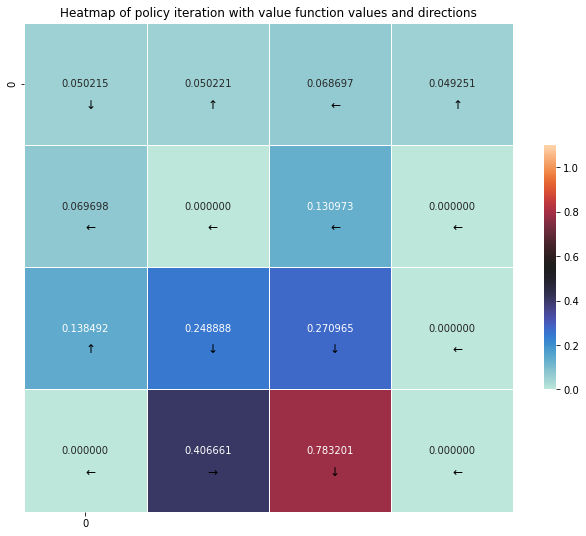

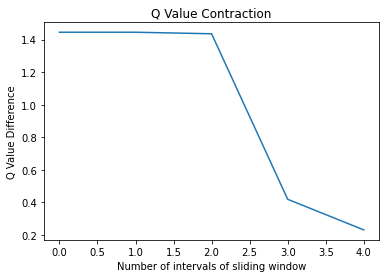

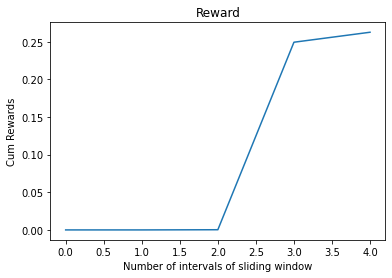

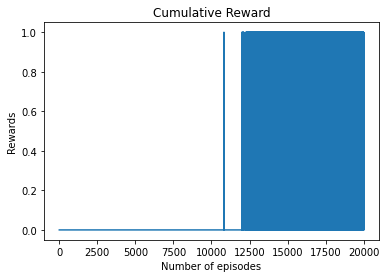

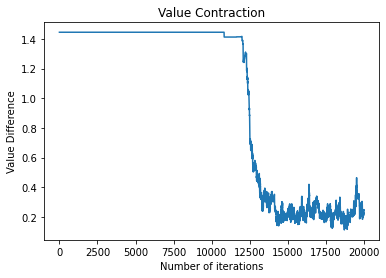

Q value: 
[[0.04912474 0.05021548 0.04909227 0.04817825]
 [0.03165483 0.03651273 0.03400976 0.05022056]
 [0.06869659 0.04799539 0.05282097 0.04723452]
 [0.02848323 0.03191266 0.03000819 0.04925096]
 [0.06969753 0.05550426 0.04837714 0.04086612]
 [0.         0.         0.         0.        ]
 [0.13097349 0.03985627 0.06585463 0.01988145]
 [0.         0.         0.         0.        ]
 [0.06910101 0.07619783 0.09736778 0.13849245]
 [0.08986481 0.24888845 0.16078844 0.12644534]
 [0.18038028 0.27096535 0.2002075  0.10625013]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.19650322 0.25578217 0.40666082 0.17858758]
 [0.39398396 0.78320136 0.44443488 0.46533225]
 [0.         0.         0.         0.        ]]
Policy from Q value: 
[1 3 0 3 0 0 0 0 3 1 1 0 0 2 1 0]
Value Function from Q value: 
[0.05021548170602965, 0.05022055552535774, 0.06869659318306842, 0.049250960098015086, 0.06969752582973127, 0.0, 0.1309734895805723, 0.0, 0.138492453173

In [3]:
import numpy as np
import gym
import pickle
import seaborn

import matplotlib.pyplot as plt


def fancy_visual(value_func, policy_int):
    grid = 4
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped = np.reshape(value_func, (grid, grid))
    seaborn.heatmap(reshaped, cmap="icefire", vmax=1.1, robust=True,
                    square=True, xticklabels=grid + 1, yticklabels=grid + 1,
                    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter = 0
    for j in range(0, 4):
        for i in range(0, 4):
            if int(policy_int[counter]) == 1:
                plt.text(i + 0.5, j + 0.7, u'\u2193', fontsize=12)
            elif int(policy_int[counter]) == 3:
                plt.text(i + 0.5, j + 0.7, u'\u2191', fontsize=12)
            elif int(policy_int[counter]) == 0:
                plt.text(i + 0.5, j + 0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i + 0.5, j + 0.7, u'\u2192', fontsize=12)
            counter = counter + 1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function', value_func)
    print('Policy', policy_int)
    plt.savefig("heatmap_ql.png", dpi=300)
    plt.show()


def get_policy(q_table):
    list_states = [state for state in range(q_table.shape[0])]
    policy = np.array([0 for x in list_states])
    for state in list_states:
        policy[state] = np.argmax(q_table[state])

    return policy


def get_value_function(q_table):
    list_states = [state for state in range(q_table.shape[0])]
    value_function = []
    for state in list_states:
        x = q_table[state]
        # print(q_table[state], max(x))
        val = max(q_table[state])
        value_function.append(val)

    return value_function


def perform_q_learning():
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    env = env.unwrapped
    x = env.observation_space
    y = env.action_space
    q_table = np.zeros([env.observation_space.n, env.action_space.n])

    with open(f"q_val_tab.pkl", "rb") as fh:
        q_opt = pickle.load(fh)

    # % % time
    """Training the agent"""

    import random

    # from IPython.display import clear_output

    # Hyperparameters
    alpha = 0.1
    gamma = 0.9
    epsilon = 0.1
    num_episodes = 20000

    # For plotting metrics
    all_epochs = []
    all_penalties = []
    cum_rewards = []
    list_q_diff = []
    for i in range(1, num_episodes):
        state = env.reset()

        epochs, penalties, reward, cum_reward = 0, 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore action space
            else:
                action = np.argmax(q_table[state])  # Exploit learned values

            next_state, reward, done, info = env.step(action)
            cum_reward += reward
            # print(next_state, reward, done, info)

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state
            epochs += 1

        diff = q_table - q_opt
        list_q_diff.append(np.linalg.norm(diff, ord=2))

        cum_rewards.append(cum_reward)

    policy = get_policy(q_table)
    value_function = get_value_function(q_table)
    fancy_visual(value_function, policy)

    plot_list_q_diff(list_q_diff, cum_rewards)

    plt.plot([i for i in range(len(cum_rewards))], cum_rewards)
    plt.xlabel("Number of episodes")
    plt.ylabel("Rewards")
    plt.title("Cumulative Reward")
    plt.savefig("q_learning_cumulative_reward.png", dpi=300)
    plt.show()

    num_iterations = [i for i in range(len(list_q_diff))]
    plt.plot(num_iterations, list_q_diff)
    plt.xlabel("Number of iterations")
    plt.ylabel("Value Difference")
    plt.title("Value Contraction")
    plt.savefig("q_learning_Contraction.png", dpi=300)
    plt.show()

    print(f"Q value: \n{q_table}")
    print(f"Policy from Q value: \n{policy}")
    print(f"Value Function from Q value: \n{value_function}")

    print("Training finished.\n")


def plot_list_q_diff(list_q_diff, list_rewards):
    num_intervals = 5
    interval = len(list_q_diff) // 5
    list_avg_q = []
    list_avg_r = []
    for inter in range(num_intervals):
        avg_q = sum(list_q_diff[inter*interval: (inter+1)*interval])/interval
        avg_r = sum(list_rewards[inter*interval: (inter+1)*interval])/interval
        list_avg_q.append(avg_q)
        list_avg_r.append(avg_r)

    x = [i for i in range(num_intervals)]
    plt.plot(x, list_avg_q)
    plt.xlabel("Number of intervals of sliding window")
    plt.ylabel("Q Value Difference")
    plt.title("Q Value Contraction")
    plt.savefig("q_learning_sw_q_contraction.png", dpi=300)
    plt.show()

    x = [i for i in range(num_intervals)]
    plt.plot(x, list_avg_r)
    plt.xlabel("Number of intervals of sliding window")
    plt.ylabel("Cum Rewards")
    plt.title("Reward")
    plt.savefig("q_learning_sw_r.png", dpi=300)
    plt.show()


if __name__ == '__main__':
    # with open(f"q_val_tab.pkl", "rb") as fh:
    #     q_opt = pickle.load(fh)
    # vf = get_value_function(q_opt)
    # print(vf)
    perform_q_learning()
